## Data Preparation

In [1]:
import nltk
import itertools
import matplotlib.pyplot as plt
from sklearn_crfsuite import metrics
import sklearn_crfsuite

%matplotlib inline

In [9]:
train_file = "./emerging_entities_17/wnut17train.conll"
val_file = "./emerging_entities_17/emerging.dev.conll"
test_file = "./emerging_entities_17/emerging.test.conll"

In [10]:
!head -50 ./emerging_entities_17/wnut17train.conll

@paulwalk	O
It	O
's	O
the	O
view	O
from	O
where	O
I	O
'm	O
living	O
for	O
two	O
weeks	O
.	O
Empire	B-location
State	I-location
Building	I-location
=	O
ESB	B-location
.	O
Pretty	O
bad	O
storm	O
here	O
last	O
evening	O
.	O
	
From	O
Green	O
Newsfeed	O
:	O
AHFA	B-group
extends	O
deadline	O
for	O
Sage	O
Award	O
to	O
Nov	O
.	O
5	O
http://tinyurl.com/24agj38	O
	
Pxleyes	B-corporation
Top	O
50	O
Photography	O
Contest	O
Pictures	O


In [11]:
def read_file_to_dataset(file: str, sep: str = "\t"):
    sent_bio = []
    with open(file, "r") as f:
        for line in f.readlines():
            # remove the blank token at the beginning or end of a sentence
            line = line.strip()
            # continue for ""
            if not line:
                postags = nltk.pos_tag([w for (w,l) in sent_bio])
                data = [item + (sent_bio[i][1], ) for i, item in enumerate(postags)]
                yield data
                sent_bio = []
                continue
            word, labels = line.split(sep)
            # choose the last label
            label = labels.split(",")[-1]
            sent_bio.append((word, label))                

In [12]:
train_sents = list(read_file_to_dataset(train_file))
val_sents = list(read_file_to_dataset(val_file))
test_sents = list(read_file_to_dataset(test_file))

print(len(train_sents), len(val_sents), len(test_sents))
print(train_sents[0])

3394 1009 1287
[('@paulwalk', 'VB', 'O'), ('It', 'PRP', 'O'), ("'s", 'VBZ', 'O'), ('the', 'DT', 'O'), ('view', 'NN', 'O'), ('from', 'IN', 'O'), ('where', 'WRB', 'O'), ('I', 'PRP', 'O'), ("'m", 'VBP', 'O'), ('living', 'VBG', 'O'), ('for', 'IN', 'O'), ('two', 'CD', 'O'), ('weeks', 'NNS', 'O'), ('.', '.', 'O'), ('Empire', 'NNP', 'B-location'), ('State', 'NNP', 'I-location'), ('Building', 'NNP', 'I-location'), ('=', 'NNP', 'O'), ('ESB', 'NNP', 'B-location'), ('.', '.', 'O'), ('Pretty', 'NNP', 'O'), ('bad', 'JJ', 'O'), ('storm', 'NN', 'O'), ('here', 'RB', 'O'), ('last', 'JJ', 'O'), ('evening', 'NN', 'O'), ('.', '.', 'O')]


In [15]:
labels = set([lab for (t, p, lab)  in itertools.chain(*train_sents)])
print(len(labels))
labels

13


{'B-corporation',
 'B-creative-work',
 'B-group',
 'B-location',
 'B-person',
 'B-product',
 'I-corporation',
 'I-creative-work',
 'I-group',
 'I-location',
 'I-person',
 'I-product',
 'O'}

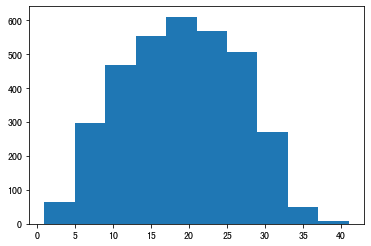

In [6]:
# print the lengths
lengths = []
for sen in train_sents:
    lengths.append(len(sen))
plt.hist(lengths);

## a. CRF

### Features

In [16]:
# it's the same as the reference
# we could modify the features
def word2features(sent, i):
    
    word = sent[i][0]
    postag = sent[i][1]

    # add more word features
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-1:]': word[-1:],
        'word[1:]': word[1:],
        'word[2:]': word[2:],
        'word[3:]': word[3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        # Indicate that it is the 'beginning of a document'
        features['BOS'] = True
        
    
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        # Features for words that are not at the end of a document
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [20]:
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

### Training

In [21]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

### Evaluation

In [22]:
labels = list(crf.classes_)
labels.remove('O')
print(labels)

y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)

['B-location', 'I-location', 'B-group', 'B-corporation', 'B-person', 'B-creative-work', 'B-product', 'I-person', 'I-creative-work', 'I-corporation', 'I-group', 'I-product']


0.1352670611299168

In [23]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-corporation', 'I-corporation', 'B-creative-work', 'I-creative-work', 'B-group', 'I-group', 'B-location', 'I-location', 'B-person', 'I-person', 'B-product', 'I-product'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                 precision    recall  f1-score   support

  B-corporation      0.200     0.011     0.021        89
  I-corporation      0.000     0.000     0.000        32
B-creative-work      0.000     0.000     0.000       131
I-creative-work      0.167     0.023     0.041       172
        B-group      0.308     0.023     0.043       175
        I-group      0.125     0.015     0.027        66
     B-location      0.381     0.316     0.346       117
     I-location      0.417     0.303     0.351        33
       B-person      0.491     0.150     0.230       373
       I-person      0.456     0.243     0.317       107
      B-product      0.750     0.029     0.056       103
      I-product      0.167     0.016     0.029        62

      micro avg      0.391     0.098     0.157      1460
      macro avg      0.288     0.094     0.122      1460
   weighted avg      0.333     0.098     0.135      1460



## b. Softmax

In [2]:
import pprint
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from functools import partial
import itertools

pp = pprint.PrettyPrinter()

### Dataset

In [3]:
# all labels in dataset
def get_labels(train_sents, without_bio: bool = False):
    ls = set()
    for sen in train_sents:
        for token in sen:
            label = token[2]
            # without B I O
            if without_bio and label != "O":
                label = label[2:]
            ls.add(label)
    return list(ls)

In [4]:
# build dataset for training and testing
def make_dataset(dataset, label_dict, without_bio: bool = False):
    sents_sm = []
    labels_sm = []
    for sent_item in dataset:
        sent_sm = []
        label_sm = []
        for token in sent_item:
            sent_sm.append(token[0])
            tag = token[2]
            if without_bio and tag != "O":
                tag = token[2][2:]
            label = label_dict.get(tag)
            label_sm.append(label)
        sents_sm.append(sent_sm)
        labels_sm.append(label_sm)
    return sents_sm, labels_sm

In [5]:
def convert_tokens_to_inds(sentence, word_2_id):
    return [word_2_id.get(t, word_2_id["<unk>"]) for t in sentence]

In [6]:
def pad_sentence_for_window(sentence, window_size, pad_token="<pad>"):
    return [pad_token]*window_size + sentence + [pad_token]*window_size 

In [79]:
def my_collate(data, window_size, word_2_id, num_labels):
    """
    For some chunk of sentences and labels
        -add winow padding
        -pad for lengths using pad_sequence
        -convert our labels to one-hots
        -return padded inputs, one-hot labels, and lengths
    """
    
    x_s, y_s = zip(*data)

    # deal with input sentences as we've seen
    window_padded = [convert_tokens_to_inds(pad_sentence_for_window(sentence, window_size), word_2_id)
                                                                                  for sentence in x_s]
    # append zeros to each list of token ids in batch so that they are all the same length
    padded = nn.utils.rnn.pad_sequence([torch.LongTensor(t) for t in window_padded], batch_first=True)
    
    # directily add labels
    labels = []
    lengths = []
    for y in y_s:
        lengths.append(len(y))
        label = torch.LongTensor(y)
        labels.append(label)
    padded_labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-1)
    
    return padded.long(), padded_labels, torch.LongTensor(lengths)

In [80]:
# labels for softmax classifier
labels = get_labels(train_sents, True)
label2id = dict(zip(list(sorted(labels, key=lambda x: x[1:])), range(len(labels))))
id2label = dict(zip(label2id.values(), label2id.keys()))
label2id

{'O': 0,
 'person': 1,
 'location': 2,
 'corporation': 3,
 'creative-work': 4,
 'product': 5,
 'group': 6}

In [81]:
train_sents_sm, train_labels_sm = make_dataset(train_sents, label2id, True)
val_sents_sm, val_labels_sm = make_dataset(val_sents, label2id, True)
test_sents_sm, test_labels_sm = make_dataset(test_sents, label2id, True)

In [82]:
id2word = ["<pad>", "<unk>"]
id2word += list(set(itertools.chain(*train_sents_sm)))
word2id = {w:i for i,w in enumerate(id2word)}
len(word2id)

14880

In [83]:
example_loader = torch.utils.data.DataLoader(
    list(zip(train_sents_sm, train_labels_sm)), 
    batch_size=2, shuffle=True, 
    collate_fn=partial(my_collate, window_size=2, word_2_id=word2id, num_labels=len(label2id)))

In [84]:
for batched_input, batched_labels, batch_lengths in example_loader:
    pp.pprint(("inputs", batched_input, batched_input.size()))
    pp.pprint(("labels", batched_labels, batched_labels.size()))
    pp.pprint(batch_lengths)
    break

('inputs',
 tensor([[    0,     0,  4003,  3847, 11569,  6764, 10183, 10680, 13454,  4946,
         12455, 13327,  4003, 11583,  1135,  3852,  8010, 14237,  6802, 10189,
          4321, 14643, 12145,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,  7328,  3276, 13232, 13758,  4737, 11481,  1006, 14479,
         10680, 14082,  1135,  6444,  4711,  8511,  5587,  8511,  3298, 12145,
         10504,  2834,  6153,  9990,  7869,  4654,  8881, 12145,     0,     0]]),
 torch.Size([2, 30]))
('labels',
 tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0]]),
 torch.Size([2, 26]))
tensor([21, 26])


### Model

In [85]:
class SoftmaxWordWindowClassifier(nn.Module):
    def __init__(self, config, vocab_size, pad_idx=0):
        super(SoftmaxWordWindowClassifier, self).__init__()
        self.window_size = 2*config["half_window"]+1
        self.embed_dim = config["embed_dim"]
        self.hidden_dim = config["hidden_dim"]
        self.num_classes = config["num_classes"]
        self.freeze_embeddings = config["freeze_embeddings"]
        self.embed_layer = nn.Embedding(vocab_size, self.embed_dim, padding_idx=pad_idx)
        if self.freeze_embeddings:
            self.embed_layer.weight.requires_grad = False
        self.hidden_layer = nn.Sequential(nn.Linear(self.window_size*self.embed_dim, 
                                                    self.hidden_dim), 
                                          nn.Tanh())
        self.output_layer = nn.Linear(self.hidden_dim, self.num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)
        # add dropout to avoid overfitting
        self.dropout = nn.Dropout(config["dropout_prob"])
        
    def forward(self, inputs):
        B, L = inputs.size()
        token_windows = inputs.unfold(1, self.window_size, 1)
        _, adjusted_length, _ = token_windows.size()
        assert token_windows.size() == (B, adjusted_length, self.window_size)
        embedded_windows = self.embed_layer(token_windows)
        embedded_windows = embedded_windows.view(B, adjusted_length, -1)
        embedded_windows = self.dropout(embedded_windows)
        layer_1 = self.hidden_layer(embedded_windows)
        layer_1 = self.dropout(layer_1)
        output = self.output_layer(layer_1)
        output = output.view(-1, output.shape[2])
        output = self.dropout(output)
        output = self.log_softmax(output)
        return output

### Training

In [130]:
def loss_function(outputs, labels, lengths):
    labels = labels.view(-1)
    # mask padded labels
    mask = (labels >= 0).float()
    num_elems = lengths.sum().float()
    return -torch.sum(outputs[range(outputs.shape[0]), labels] * mask) / num_elems

In [131]:
def train_epoch(loss_function, optimizer, model, train_data):
    ## For each batch, we must reset the gradients
    ## stored by the model.   
    total_loss = 0
    batch_num = len(train_data)
    for batch, labels, lengths in train_data:
        # clear gradients
        optimizer.zero_grad()
        # evoke model in training mode on batch
        outputs = model(batch)
        # compute loss w.r.t batch
        loss = loss_function(outputs, labels, lengths)
        # pass gradients back, startiing on loss value
        loss.backward()
        # update parameters
        optimizer.step()
        total_loss += loss.item()
    
    # return the total to keep track of how you did this time around
    return total_loss / batch_num

In [132]:
def test_epoch(loss_function, optimizer, model, test_data):
    total_loss = 0
    batch_num = len(test_data)
    for batch, labels, lengths in test_data:
        with torch.no_grad():
            outputs = model(batch)
        loss = loss_function(outputs, labels, lengths)
        total_loss += loss.item()
    return total_loss / batch_num

In [133]:
def train(num_epochs, loss_function, optimizer, model, train_loader, val_loader):
    losses = []
    for epoch in range(num_epochs):
        train_loss = train_epoch(loss_function, optimizer, model, train_loader)
        val_loss = test_epoch(loss_function, optimizer, model, val_loader)
        if epoch % 10 == 0:
            print(train_loss, val_loss)
        losses.append(train_loss)
    return losses

In [142]:
config = {"batch_size": 16,
          "half_window": 2,
          "embed_dim": 32,
          "hidden_dim": 32,
          "num_classes": len(label2id),
          "freeze_embeddings": False,
          "dropout_prob": 0.5
         }
learning_rate = 0.0002
num_epochs = 20
model = SoftmaxWordWindowClassifier(config, len(word2id))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [143]:
train_loader = torch.utils.data.DataLoader(
    list(zip(train_sents_sm, train_labels_sm)), 
    batch_size=config["batch_size"], shuffle=True, 
    collate_fn=partial(my_collate, window_size=2, word_2_id=word2id, num_labels=len(label2id)))
val_loader = torch.utils.data.DataLoader(
    list(zip(val_sents_sm, val_labels_sm)), 
    batch_size=config["batch_size"], shuffle=True, 
    collate_fn=partial(my_collate, window_size=2, word_2_id=word2id, num_labels=len(label2id)))
labels = [id for id in id2label.keys() if id2label.get(id) != "O"]
test_loader = torch.utils.data.DataLoader(
    list(zip(test_sents_sm, test_labels_sm)), 
    batch_size=1, shuffle=False, 
    collate_fn=partial(my_collate, window_size=2, word_2_id=word2id, num_labels=len(label2id)))

In [144]:
history = train(num_epochs, loss_function, optimizer, model, train_loader, val_loader)

1.8588769609379656 1.6388171650469303
0.898311006351256 1.0224702069535851


### Evaluation

In [145]:
def print_score(model, test_loader, labels, output_report: bool = False):
    y_preds = []
    y_trues = []
    for test_instance, labs, _ in test_loader:
        outputs = model(test_instance)
        y_pred = torch.argmax(outputs, dim=1).detach().numpy()
        y_preds.append(y_pred.tolist())
        y_trues.append(labs.numpy().tolist()[0])

    print(metrics.flat_f1_score(y_trues, y_preds, average='weighted', labels=labels))
    if output_report:
        print(metrics.flat_classification_report(y_trues, y_preds, labels=labels, digits=3))

In [146]:
print_score(model, test_loader, labels, True)

0.014403366892435657
              precision    recall  f1-score   support

           1      0.022     0.008     0.012       480
           2      0.005     0.013     0.008       150
           3      0.005     0.033     0.009       121
           4      0.013     0.059     0.021       303
           5      0.006     0.109     0.012       165
           6      0.010     0.245     0.019       241

   micro avg      0.009     0.072     0.016      1460
   macro avg      0.010     0.078     0.013      1460
weighted avg      0.013     0.072     0.014      1460



## Hyper

In [148]:
# learning_rate
config = {"batch_size": 16,
          "half_window": 2,
          "embed_dim": 32,
          "hidden_dim": 32,
          "num_classes": len(label2id),
          "freeze_embeddings": False,
          "dropout_prob": 0.5
         }
num_epochs = 20
for learning_rate in [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]:
    model = SoftmaxWordWindowClassifier(config, len(word2id))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = train(num_epochs, loss_function, optimizer, model, train_loader, val_loader)
    print_score(model, test_loader, labels)

1.4410284550536967 1.708241581916809
1.560937524401526 2.139604428783059
0.016890647072350433
0.9663480002555489 1.0672624865546823
0.9370820693007098 1.1078242929652333
0.02049186248014537
0.9484141631305497 1.0670955423265696
0.8341157732994904 1.1148025076836348
0.023277226161830457
0.9893727131852521 0.9949080757796764
0.7695537178729062 1.0123037388548255
0.036716223301551006
1.0412188832748663 1.010098141618073
0.7901834747601003 0.9805597104132175
0.03349212048065159
1.4221635362911673 1.1958199199289083
0.8702562367412406 0.9743502447381616
0.03975807180265422


In [150]:
# embed_dim
config = {"batch_size": 16,
          "half_window": 2,
          "embed_dim": 32,
          "hidden_dim": 32,
          "num_classes": len(label2id),
          "freeze_embeddings": False,
          "dropout_prob": 0.5
         }
num_epochs = 20
for embed_dim in [8, 16, 32, 64, 128]:
    print("Embedding dim: ", embed_dim)
    config["embed_dim"] = embed_dim
    model = SoftmaxWordWindowClassifier(config, len(word2id))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = train(num_epochs, loss_function, optimizer, model, train_loader, val_loader)
    print_score(model, test_loader, labels)

Embedding dim:  8
1.4760623784132407 1.0877766348421574
0.8945051778650059 1.0170803032815456
0.014162787385496645
Embedding dim:  16
1.4133415977719803 1.0690827462822199
0.8776822509899945 0.9964117547497153
0.018244525124492025
Embedding dim:  32
1.4524243331291307 1.158347962424159
0.8690206109078278 0.9839324643835425
0.028954863156406573
Embedding dim:  64
1.4002246901462896 1.1191635075956583
0.8541542006210542 1.040855348110199
0.01936489972611207
Embedding dim:  128
1.3341651349000527 1.0886969985440373
0.8346883106119756 1.0053897723555565
0.0334319894330069


In [151]:
# hidden_dim
config = {"batch_size": 16,
          "half_window": 2,
          "embed_dim": 32,
          "hidden_dim": 32,
          "num_classes": len(label2id),
          "freeze_embeddings": False,
          "dropout_prob": 0.5
         }
num_epochs = 20
for hidden_dim in [8, 16, 32, 64, 128]:
    print("Hidden dim: ", hidden_dim)
    config["hidden_dim"] = hidden_dim
    model = SoftmaxWordWindowClassifier(config, len(word2id))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = train(num_epochs, loss_function, optimizer, model, train_loader, val_loader)
    print_score(model, test_loader, labels)

Hidden dim:  8
1.4175758417783209 1.2223599776625633
0.8804250116079626 0.9924459545873106
0.03233573211758958
Hidden dim:  16
1.4871680949215598 1.1335263084620237
0.8771239267268651 1.0420225774869323
0.015494697653027044
Hidden dim:  32
1.3766505175353216 1.1125110322609544
0.8671806449061829 0.9882329208776355
0.02842914492782242
Hidden dim:  64
1.336010734520048 1.0632217479869723
0.861740357719117 0.9732221411541104
0.026659755194059456
Hidden dim:  128
1.2550609842152662 1.0291369846090674
0.8683240122638398 0.9885111544281244
0.022806557998367488


In [152]:
# epoches
config = {"batch_size": 16,
          "half_window": 2,
          "embed_dim": 32,
          "hidden_dim": 32,
          "num_classes": len(label2id),
          "freeze_embeddings": False,
          "dropout_prob": 0.5
         }
learning_rate = 0.001
for num_epochs in [1, 5, 10, 20, 50]:
    print("Num epochs: ", num_epochs)
    model = SoftmaxWordWindowClassifier(config, len(word2id))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = train(num_epochs, loss_function, optimizer, model, train_loader, val_loader)
    print_score(model, test_loader, labels)

Num epochs:  1
1.4438380467499925 1.1052329828962684
0.011253401801668726
Num epochs:  5
1.4099277935117622 1.2587079666554928
0.01381389448173674
Num epochs:  10
1.4859351185565823 1.2159945983439684
0.016440546845950553
Num epochs:  20
1.5102287841514803 1.199783032760024
0.8725363749293654 1.0607517715543509
0.024727275920377267
Num epochs:  50
1.470889863553741 1.1230453215539455
0.8784864687583815 1.0052653532475233
0.8309886200886937 1.0564784109592438
0.8058597495858099 1.0399972451850772
0.7837466368093177 1.0417290180921555
0.023241701029266
